# Which MMSI are Used by Multiple Vessels?

This is the fourth take at getting a good spoofing list.
This is a copy of segment_overlap_2015_v4, except changing all 2015 to 2014

1) Eliminate all segments that have fewer than 100 points and are all terrestrial, and which are not clumped right next to the equator or prime meridian. This will get rid of many valid segments, but it will also eliminate most of the noise. (A beter analysis will later get rid of more noise). 

```
SELECT
  * from(
  SELECT
    mmsi,
    seg_id,
    first_timestamp,
    last_timestamp,
    LAG(last_timestamp,1) OVER (PARTITION BY mmsi ORDER BY first_timestamp) last_previous_segment,
    LEAD(first_timestamp,1) OVER (PARTITION BY mmsi ORDER BY first_timestamp) first_next_segment
  FROM
    [scratch_david_seg_analysis.2014_segments]
  WHERE
    (point_count >=100
      OR (point_count>10
        AND terrestrial_positions != point_count))
    AND (last_timestamp - first_timestamp)/3600000000 > 12 // more than 12 hours
    AND NOT ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225)) )
WHERE
  mmsi IN (
  SELECT
    mmsi
  FROM
        [scratch_david_mmsi_lists.Combinedfishing_2014])
```
Save to table: `[scratch_david_seg_analysis.good_fishing_segments_2014]`

2) Look at segments that overlap, and ignore the ones that should not be brocken up into different segments -- that is, look at the average distance between consecutive points, and determine if they are realistic segments. We have to eliminate these because it looks like the segmenter was dividing what should be continuous segments into different segments, which in turn made some vessels have overlap which clearly did not have overlap.

```
SELECT
  seg_id
FROM (
  SELECT
    a.mmsi mmsi,
    b.seg_id seg_id,
    b.first_timestamp overalp_start,
    IF(a.last_timestamp < b.last_timestamp, a.last_timestamp, b.last_timestamp) overlap_end,
    /*a.first_timestamp,
      b.first_timestamp,
      a.last_timestamp,
      b.last_timestamp,
      IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,*/
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.good_fishing_segments_2014] a
    JOIN
      [scratch_david_seg_analysis.good_fishing_segments_2014] b
    ON
      a.mmsi = b.mmsi)
  WHERE
    a.first_timestamp < b.first_timestamp
    AND b.first_timestamp < a.last_timestamp),
  (
  SELECT
    a.mmsi mmsi,
    a.seg_id seg_id,
    b.first_timestamp overalp_start,
    IF(a.last_timestamp < b.last_timestamp, a.last_timestamp, b.last_timestamp) overlap_end,
    /*a.first_timestamp,
      b.first_timestamp,
      a.last_timestamp,
      b.last_timestamp,
      IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,*/
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.good_fishing_segments_2014] a
    JOIN
      [scratch_david_seg_analysis.good_fishing_segments_2014] b
    ON
      a.mmsi = b.mmsi)
  WHERE
    a.first_timestamp < b.first_timestamp
    AND b.first_timestamp < a.last_timestamp)
GROUP BY
  seg_id
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2_2014]`
This lists all the segements that are overlapping in time

```
SELECT
  mmsi,
  seg_id,
  next_seg_id,
  timestamp,
  if (gap_seconds = 0,
    gapmeters/(.000001),
    gapmeters/gap_seconds) speed,
  gapmeters,
  gap_seconds,
FROM (
SELECT
  mmsi,
  seg_id,
  next_seg_id,
  timestamp,
  lat,
  lon,
  next_lat,
  next_lon,
  (ACOS(COS(RADIANS(90-lat)) *COS(RADIANS(90-next_lat)) +SIN(RADIANS(90-lat)) *SIN(RADIANS(90-next_lat)) * COS(RADIANS(lon-next_lon)))*6371000) gapmeters,
  (next_timestamp - timestamp)/1000000 gap_seconds
FROM (
  SELECT
    mmsi,
    seg_id,
    LEAD(seg_id, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_seg_id,
    timestamp,
    LEAD(timestamp, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_timestamp,
    lat,
    lon,
    LEAD(lat, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lat,
    LEAD(lon, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lon,
  FROM (
    SELECT
      mmsi,
      seg_id,
      lat,
      lon,
      timestamp,
      type
    FROM (
      SELECT
        mmsi,
        seg_id,
        lat,
        lon,
        timestamp,
        type
      FROM
        TABLE_DATE_RANGE([pipeline_classify_fishing.], TIMESTAMP('2014-01-01'), TIMESTAMP('2014-12-31')))
    WHERE
      seg_id IN (
      SELECT
        seg_id
      FROM
        [scratch_david_seg_analysis.overlapping_segments_v2_2014])
      AND type IN (1,2,3,18,19)
      AND lat IS NOT NULL
      AND lon IS NOT NULL) )
WHERE
  seg_id != next_seg_id)
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_2014]`
This cacluates how the vessel jumps back and forth between two segments, calculating the time and distance between two consecutive points that are in different segments.


```
SELECT
    mmsi,
    seg_id,
    next_seg_id,
    AVG(gap_seconds) avg_gap_seconds,
    SUM(gap_seconds) tot_gap_seconds,
    AVG(gapmeters) avg_gap_meters,
    SUM(gapmeters) tot_gap_meters,
    IF(SUM(gap_seconds)=0, if (avg_gap_meters < 10000, 10,100000), AVG(gapmeters)/AVG(gap_seconds)) avg_speed,
    COUNT(*) jumps
  FROM
    [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_2014]
  WHERE
    speed IS NOT NULL
    AND gapmeters >=0
  GROUP BY
    mmsi,
    seg_id,
    next_seg_id
  ORDER BY
    avg_speed ASC
```

Save to [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_2014]


```
SELECT
  seg_id,
  next_seg_id,
  tot_gap_seconds,
  tot_gap_meters,
  tot_jumps,
  tot_gap_meters/tot_gap_seconds avg_speed
FROM (
  SELECT
    IF(a.seg_id > a.next_seg_id, a.seg_id, a.next_seg_id) seg_id,
    IF(a.seg_id > a.next_seg_id, a.next_seg_id, a.seg_id) next_seg_id,
    a.tot_gap_seconds + IF(b.tot_gap_seconds IS NULL, 0,b.tot_gap_seconds) tot_gap_seconds,
    a.tot_gap_meters + IF(b.tot_gap_meters IS NULL, 0,b.tot_gap_meters) tot_gap_meters,
    a.jumps + IF(b.jumps IS NULL, 0,b.jumps) tot_jumps,
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_2014] a
    LEFT JOIN
      [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_2014] b
    ON
      a.seg_id = b.next_seg_id
      AND a.next_seg_id = b.seg_id)
  GROUP BY
    seg_id,
    next_seg_id,
    tot_gap_seconds,
    tot_gap_meters,
    tot_jumps )
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_b_2014]`

The results of these two queries are a list of pairs of segements and the average distance between points on them that are consecutive in time.

3) Sum the overlapping time by vessel, including only the segements above that are physically impossible (in this case where the aveage speed has to be >100 knots in order to jump between the two segments). This is done below.




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
import bq
import time
import cPickle 
from mpl_toolkits.basemap import Basemap

In [4]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [5]:
# This query looks at only 2015, and only fishing vessels

q = '''
SELECT
  a.mmsi mmsi,
  ROUND(a.spoofing_hours,1) spoofing_hours,
  ROUND(b.total_hours,1) total_hours,
  ROUND(100*a.spoofing_hours/b.total_hours,2) spoofing_percent,
  a.overlapping_segments overlapping_segments,
  b.num_segments num_segments
FROM (
  SELECT
    mmsi,
    SUM(spoofing_hours) spoofing_hours,
    COUNT(*) overlapping_segments
  FROM (
    SELECT
      *,
      CONCAT(seg_id, next_seg_id) segs
    FROM (
      SELECT
        a.mmsi mmsi,
        IF(a.seg_id > b.seg_id, a.seg_id, b.seg_id) seg_id,
        IF(a.seg_id > b.seg_id, b.seg_id, a.seg_id) next_seg_id,
        IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,
      FROM (
        SELECT
          *
        FROM
          [scratch_david_seg_analysis.good_fishing_segments_2014] a
        JOIN
          [scratch_david_seg_analysis.good_fishing_segments_2014] b
        ON
          a.mmsi = b.mmsi)
      WHERE
        a.first_timestamp < b.first_timestamp
        AND b.first_timestamp < a.last_timestamp)
    HAVING
      segs IN (
      SELECT
        CONCAT(seg_id, next_seg_id) segs
      FROM
        [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_b_2014]
      WHERE
        avg_speed > 100))
  GROUP BY
    mmsi
  ORDER BY
    spoofing_hours DESC ) a
JOIN (
  SELECT
    mmsi,
    SUM((last_timestamp - first_timestamp))/3600000000 total_hours,
    COUNT(*) num_segments
  FROM
    [scratch_david_seg_analysis.good_fishing_segments_2015]
  GROUP BY
    mmsi ) b
ON
  a.mmsi = b.mmsi
ORDER BY
  spoofing_hours DESC'''

overlaps = Query(q)

Waiting on bqjob_r2bf70ce12a8ad21d_000001547c413f2d_1 ... (7s) Current status: DONE   
Query time: 10.7970309258 seconds.


In [6]:
print "mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments"
for i in range(len(overlaps)):
    o = overlaps[i]
    print o[0],o[1],o[2],o[3]+"%", o[4]

mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments
123456789 148422.0 85481.0 173.63% 3962
440773000 8636.7 10622.4 81.31% 35
316012880 5669.3 6737.9 84.14% 147
440787000 5054.7 12322.9 41.02% 147
367061930 3451.8 14759.5 23.39% 58
701007014 1432.4 14898.9 9.61% 41
412420502 1215.0 9962.9 12.2% 26
413222000 987.6 7300.3 13.53% 9
412888887 870.8 1352.1 64.41% 17
701006034 842.7 7703.8 10.94% 17
412331035 817.8 3760.7 21.75% 14
441072000 803.6 8752.6 9.18% 13
412400155 782.5 7387.5 10.59% 12
345140500 671.3 7295.4 9.2% 30
412448626 578.3 1570.4 36.82% 12
257303420 509.1 5181.6 9.83% 2
412447093 499.3 5098.4 9.79% 10
412412444 476.0 3946.2 12.06% 19
412420197 458.5 9600.9 4.78% 24
412201233 412.1 2439.2 16.9% 11
238123456 399.7 8127.3 4.92% 9
412413353 398.6 2418.0 16.49% 6
412320033 386.1 4777.7 8.08% 12
412420168 374.6 4665.9 8.03% 12
413666661 332.6 3020.7 11.01% 10
416004507 326.2 6777.9 4.81% 10
412449961 305.0 3927.6 7.77% 9
800000029 300.7 454.3 66.18% 5
90030030

In [7]:
print "total number of vessels with at least one overlap:", len(overlaps)

total number of vessels with at least one overlap: 271


In [8]:
for i in range(len(overlaps)):
    o = overlaps[i]
    if o[0] == '258154000':
        print o

# Let's map some of these



In [11]:
def map_mmsi(mmsi, title = ""):
    if title == "":
        title = 'Vessel '+str(mmsi)
    plt.rcParams["figure.figsize"] = [12,7]
    q = ''' select * from (select timestamp, lat, lon, speed, seg_id 
    FROM (TABLE_DATE_RANGE([pipeline_classify.], TIMESTAMP('2014-01-01'), TIMESTAMP('2014-12-31')))
    where mmsi = '''+str(mmsi) + '''
    and lat is not null and lon is not null 
    and lat <90 and lat>-90 and lon<180 and lon>-180)
    where seg_id in (select seg_id from [scratch_david_seg_analysis.good_fishing_segments_2014]
    where mmsi ='''+str(mmsi) + ''' )
    order by timestamp'''

    ves = Query(q)

    lats = np.array([float(v[1]) for v in ves])
    lons = np.array([float(v[2]) for v in ves])

    min_lat = min(lats)
    min_lon = min(lons)
    max_lat = max(lats)
    max_lon = max(lons)

    if max_lat>90: max_lat = 90
    if min_lat<-90: min_lat = -90

    m =\
    Basemap(llcrnrlon=min_lon,llcrnrlat=min_lat,urcrnrlon=max_lon,urcrnrlat=max_lat,projection='mill', resolution ='l')

    m.drawmapboundary()
    m.fillcontinents("#cccccc")
    x,y= m(lons,lats)
    color =  "#7879FA"   
    size = 2
    m.plot(x, y, lw=1, color = "#000000",alpha=.5)
    m.plot(x, y, marker = 'o', alpha=.5,lw=0, ms=5,markeredgecolor = 'none',color = "#FF0000")
    plt.title(title)   
    plt.savefig(str(mmsi)+".png",bbox_inches='tight',dpi=900,transparent=True,pad_inches=.1)
    plt.show()
    plt.clf()


Waiting on bqjob_r2ec8b9fec8724966_000001547c579e05_3 ... (23s) Current status: DONE   
Query time: 27.6318910122 seconds.


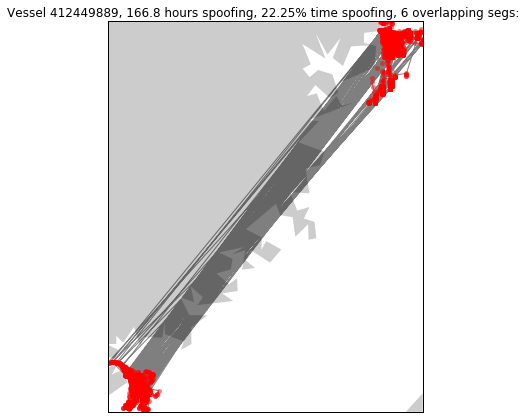

Waiting on bqjob_r5666a2e984bca7aa_000001547c58560c_4 ... (23s) Current status: DONE   
Query time: 28.3994309902 seconds.


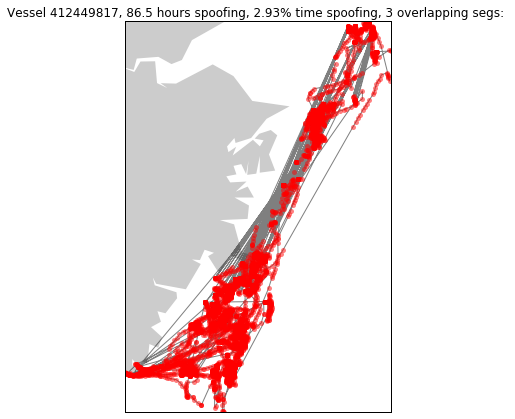

Waiting on bqjob_r57999a1e7fb415dc_000001547c590f6c_5 ... (14s) Current status: DONE   
Query time: 19.0840349197 seconds.


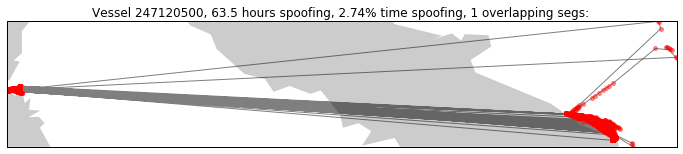

Waiting on bqjob_r54eca88177cb1f3f_000001547c59926e_6 ... (23s) Current status: DONE   
Query time: 28.41522789 seconds.


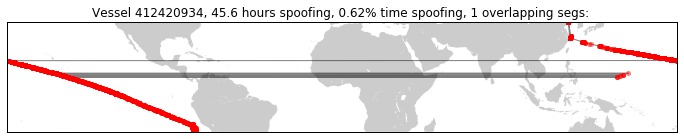

Waiting on bqjob_r2b1cdfef38cf259b_000001547c5a43fa_7 ... (15s) Current status: DONE   
Query time: 19.6467740536 seconds.


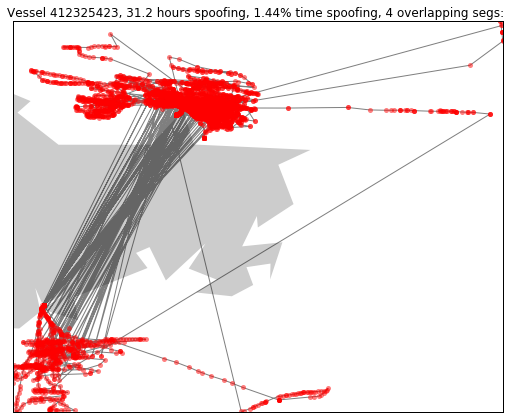

Waiting on bqjob_r721687483a980c69_000001547c5adf8e_8 ... (23s) Current status: DONE   
Query time: 27.2707209587 seconds.


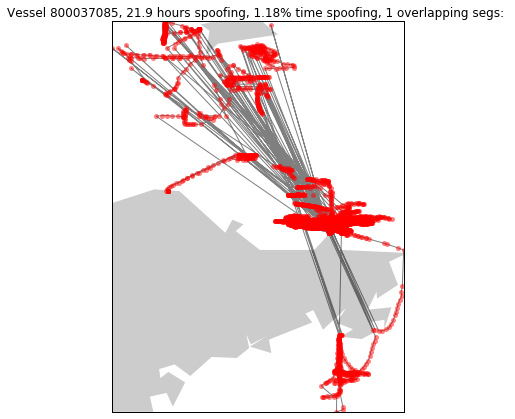

Waiting on bqjob_r7d96f3913fa32acd_000001547c5b9796_9 ... (135s) Current status: DONE   
Query time: 140.469916105 seconds.


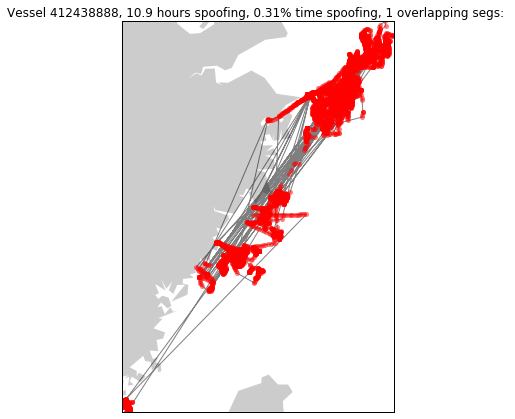

Waiting on bqjob_r58e5e5afe901243f_000001547c5e0379_10 ... (23s) Current status: DONE   
Query time: 27.4106340408 seconds.


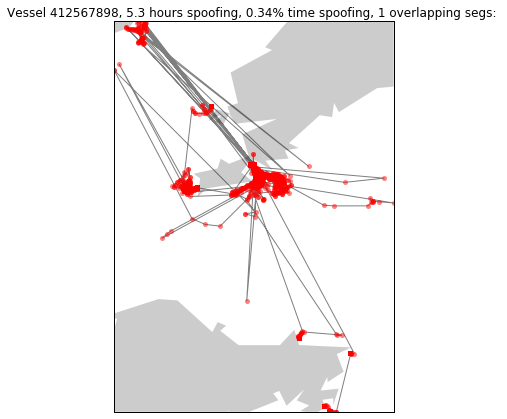

Waiting on bqjob_r89f12b7a57a0f28_000001547c5eb48c_11 ... (14s) Current status: DONE   
Query time: 19.5673210621 seconds.


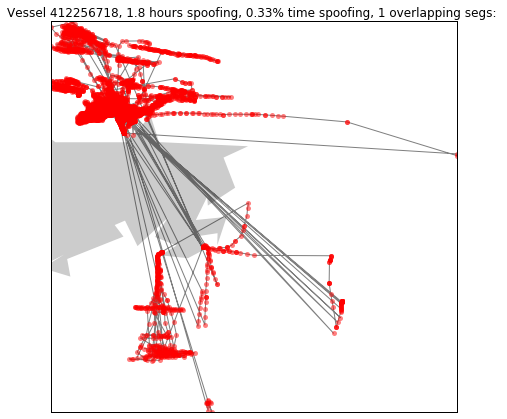

In [12]:
for i in range(50,len(overlaps),25): # no need to start on the obvious spoofing one
    o = overlaps[i]
    map_mmsi(o[0], "Vessel "+o[0] + ", "+o[1]+" hours spoofing, "+o[3]+"% time spoofing, "+o[4]+" overlapping segs: ")


In [13]:
import csv
with open('spoofing_hours_2014.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(["mmsi","spoofing_hours","total_hours","spoofing_percent","overlapping_segments","num_segments"])
    writer.writerows(overlaps)